# **VisionGPT-2 Image Captioning Model**
---

- *almost* built from scratch.
- pretrained weights loading via HF & timm
- dataset preparation from scratch as well.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/itü/projects/pattern

/content/drive/MyDrive/itü/projects/pattern


In [3]:
!ls

 annotations
 annotations_trainval2017.zip
 captioner
 captioner_distilled
 captioner_distilled_005
'cihan_calisir_BBL_514E_Project_Proposa_Document&readme.pdf'
 pattern.ipynb
 test2017
 test2017.zip
 train2017
 train2017.zip
'Untitled document.gdoc'
 val2017
 val2017.zip
 visiongpt2-image-captioning-pytorch.ipynb


# Imports
---

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

In [5]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# Dataset
---
- the dataset we're using is `COCO 2017`, it has about 500k samples, we will only use 150k samples.
- augmentations: PIL + albumentations. Fun fact: albumentations is a LOT faster than torchvision
- mean and std for ViT models is `[0.5,0.5,0.5]` unlike the standard ImageNet mean and std.

In [6]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-6-3943366170.py:11: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
/tmp/ipython-input-6-3943366170.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),


In [7]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

'<|endoftext|>'

In [8]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [9]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        caption = f"{caption}<|endoftext|>"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image, input_ids, labels

In [10]:
!pwd

/content/drive/MyDrive/itü/projects/pattern


In [11]:
# COCO 2017
import os
base_path = Path('/content/drive/MyDrive/itü/projects/pattern/')
annot = os.path.join(base_path, 'annotations/captions_train2017.json')
annot_val = os.path.join(base_path, 'annotations/captions_val2017.json')
with open(annot, 'r') as f:
    data = json.load(f)
    data = data['annotations']

    data_v = json.load(open(annot_val, 'r'))
    data_v = data_v['annotations']

In [ ]:
data[0]

{'image_id': 203564,
 'id': 37,
 'caption': 'A bicycle replica with a clock as the front wheel.'}

In [ ]:
new_data = []
train_path = os.path.join(base_path, 'train2017')
counter = 0
for i, sample in enumerate(data):
    im = '%012d.jpg' % sample['image_id']
    if os.path.exists(os.path.join(train_path, im)):
        new_data.append(sample)

In [ ]:
new_data = new_data[:100000]

In [ ]:
new_val_data = []
val_path = os.path.join(base_path, 'val2017')
for i, sample in enumerate(data_v):
    im = '%012d.jpg' % sample['image_id']
    if os.path.exists(os.path.join(val_path, im)):
        new_val_data.append(sample)

In [ ]:
new_val_data = new_val_data[:10000]

In [ ]:
len(new_val_data), len(new_data)

(10000, 100000)

In [ ]:
new_val_data[9]

{'image_id': 517069,
 'id': 882,
 'caption': 'A woman sitting on a bench and a woman standing waiting for the bus.'}

In [ ]:
samples = []

for sample in new_data:
    im = '%012d.jpg' % sample['image_id']
    samples.append([im, sample['caption']])

df_data = pd.DataFrame(samples, columns=['image', 'caption'])
df_data['image'] = df_data['image'].apply(lambda x: base_path / 'train2017' / x)


samples = []

for sample in new_val_data:
    im = '%012d.jpg' % sample['image_id']
    samples.append([im, sample['caption']])

df_val_data = pd.DataFrame(samples, columns=['image', 'caption'])
df_val_data['image'] = df_val_data['image'].apply(lambda x: base_path / 'val2017' / x)

#### some samples from the dataset

In [ ]:
df_val_data

,image,caption
0,/content/drive/MyDrive/itü/projects/pattern/v...,A black Honda motorcycle parked in front of a ...
1,/content/drive/MyDrive/itü/projects/pattern/v...,A Honda motorcycle parked in a grass driveway
2,/content/drive/MyDrive/itü/projects/pattern/v...,An office cubicle with four different types of...
3,/content/drive/MyDrive/itü/projects/pattern/v...,A small closed toilet in a cramped space.
4,/content/drive/MyDrive/itü/projects/pattern/v...,Two women waiting at a bench next to a street.
...,...,...
9995,/content/drive/MyDrive/itü/projects/pattern/v...,A row of little white teddy bears lean against...
9996,/content/drive/MyDrive/itü/projects/pattern/v...,The grey and white cat stares up near a laptop.
9997,/content/drive/MyDrive/itü/projects/pattern/v...,A white bull walks along the sidewalk near peo...
9998,/content/drive/MyDrive/itü/projects/pattern/v...,two huge elephant with tusks hidden among the ...


In [ ]:
df_data

,image,caption
0,/content/drive/MyDrive/itü/projects/pattern/t...,A bicycle replica with a clock as the front wh...
1,/content/drive/MyDrive/itü/projects/pattern/t...,A room with blue walls and a white sink and door.
2,/content/drive/MyDrive/itü/projects/pattern/t...,A car that seems to be parked illegally behind...
3,/content/drive/MyDrive/itü/projects/pattern/t...,Blue and white color scheme in a small bathroom.
4,/content/drive/MyDrive/itü/projects/pattern/t...,This is a blue and white bathroom with a wall ...
...,...,...
99995,/content/drive/MyDrive/itü/projects/pattern/t...,THERE IS A COW AND A MAN THAT IS IN THE OCEAN
99996,/content/drive/MyDrive/itü/projects/pattern/t...,A man in an apron waving a knife above his head.
99997,/content/drive/MyDrive/itü/projects/pattern/t...,A toilet in bathtub in a home bathroom
99998,/content/drive/MyDrive/itü/projects/pattern/t...,lots of people on bicycles and motor cycles


In [ ]:
sampled_df = df_data.sample(n=8)
fig, axs = plt.subplots(4, 2, figsize=(20, 30))

for i, row in enumerate(sampled_df.iterrows()):
    ax = axs[i // 2, i % 2]
    image_path = row[1]['image']
    caption = row[1]['caption']
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(caption)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_data.reset_index(drop=True,inplace=True)
df_val_data.reset_index(drop=True,inplace=True)
print(len(df_data),len(df_val_data))

100000 10000


In [ ]:
train_df, val_df = df_data, df_val_data
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

## Custom collate function
---

- allows for dynamic padding so the model doesn't have to process `max_len` sequences which would be just filled with pad tokens
- instead, every batch is padded according to the longest sequence in the batch

In [ ]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

## How the data looks:
---
- every caption is a sequence of tokens, and as it is causal language modeling where the model predicts the next token, the labels are right shifted by 1 position.
- every caption ends with the end of sentence token: eos_token (50256 : <|endoftext|>)
- in GPT models, the pad tokens are same as the eos tokens, hence we also mask the pad tokens in the labels with -100 which are ignored by cross-entropy loss' default behaviour -- check `collate_fn` to see how I masked them.

In [ ]:
dl = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=2, collate_fn=collate_fn)
_,c,l = next(iter(dl))
print(c[0])
print(l[0])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([   32,  4274,  4675,  1051, 20156,   257, 16825,   351,   257,  2245,
         1051,    13, 50256])
tensor([ 4274,  4675,  1051, 20156,   257, 16825,   351,   257,  2245,  1051,
           13, 50256,  -100])


# Model
### This is somewhat how the architecture looks now.
![](https://i.imgur.com/fk68DMo.jpg)


## Causal Attention Block
---

In [ ]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5

        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)


    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out

"""
## Cross Attention Block
---
- Notice how I initialized the parameters with mean=0. and std=0.02. This is an OpenAI trick they used while training GPT2 as well.
"""
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


    def forward(self, q,k,v):
        b,t,c = q.shape

        q = self.q(q)
        k = self.k(k)
        v = self.v(v)

        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out


"""
Feed Forward Block
"""
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout

        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)

    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


"""
Decoder Block
with added cross-attention and pre-normalization
"""
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)

    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x


"""
The main model
- creating ViT model via timm
- added embedding code and right forward pass for the ViT model as per their code.
- each encoder output is passed to the decoder input and to the next encoder input as well.
- the final decoder outputs are passed through a head block to generate logits as per the vocab size.
- loss is calculated using cross-entropy if labels are present else, logits for the final token in the sequence are returned for generation.
    - pretrained_layers_trainable: freezes/unfreezes ViT and GPT2 pretrained layers
    - unfreeze_gpt_layers: unfreezes GPT2 layers only
    - from_pretrained: loads GPT2 weights via huggingface gpt2
    - generate: generates caption, sampling via torch.multinomial or deterministic via argmax with temperature control.
"""

class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config

        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches

        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)

        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight

    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)

    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)

        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable

        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')

    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)

        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True

    @classmethod
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]

        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        model.load_state_dict(sd)

        return model

    def forward(self,image,input_ids,labels=None):

        image = self.patch_embed(image)
        image = self._pos_embed(image)

        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)

        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)

        input_ids = self.transformer.ln_f(input_ids)

        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss

        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits

    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

        return sequence.cpu().flatten()

# Training
---
- the pretrained layers are initially frozen as I need to train the cross attention layers first
- in the following epochs, GPT2 is unfreezed and trained, in the final few epochs, the ViT is unfreezed as well.
- optimizer: Adam
- scheduler: OneCycleLR
- mixed-precision fp16 training with autocast and grad-scaler in torch
- metrics: cross-entropy loss and perplexity = e^loss, both lower the better
- best model is saved based on validation perplexity and the same is loaded while generating captions.

### Generation

- GPT2 generally requires context before generating anything, since for image captioning we can't really provide an initial context except the image itself, the initial context we provide to GPT is just `[50256]` i.e `<|endoftext|>` which is also the beginning of sentence token in GPT. For other models such as OPT it is `</s>`. This one token acts as the initial context.

In [ ]:
class Trainer:
    def __init__(self,model_config,train_config, dls):

        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device

        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)

        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')

        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.scaler = GradScaler()

        self.train_dl, self.val_dl = dls

        total_steps = len(self.train_dl)

        self.optim = torch.optim.Adam(self.model.parameters(),
                                      lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )

#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None

        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])


    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')


    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)


    def train_one_epoch(self,epoch):
        prog = tqdm(self.train_dl,total=len(self.train_dl))
        running_loss = 0.
        for image, input_ids, labels in prog:
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                loss = self.model(image,input_ids,labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)

                running_loss += loss.item()

                prog.set_description(f'train loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)

        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss,train_pxp)


    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        prog = tqdm(self.val_dl,total=len(self.val_dl))
        running_loss = 0.

        for image, input_ids, labels in prog:
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image,input_ids,labels)
                running_loss += loss.item()

                prog.set_description(f'valid loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)

        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss,val_pxp)

        return val_pxp


    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()


    def fit(self,):

        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))

        for epoch in prog:
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')

            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)

            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()

            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()

            print(self.metrics.tail(1))

            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }


    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):

        self.model.eval()

        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id

        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)

        return caption

In [ ]:
"""if __name__ == '__main__':
    model_config = SimpleNamespace(
        vocab_size = 50_257,
        embed_dim = 768,
        num_heads = 12,
        seq_len = 1024,
        depth = 12,
        attention_dropout = 0.2,
        residual_dropout = 0.2,
        mlp_ratio = 4,
        mlp_dropout = 0.2,
        emb_dropout = 0.2,
    )
    train_config = SimpleNamespace(
        epochs = 10,
        freeze_epochs_gpt = 2,
        freeze_epochs_all = 2,
        lr = 1e-4,
        device = 'cuda',
        model_path = Path('captioner'),
        batch_size = 128
    )
    train_dl = torch.utils.data.DataLoader(train_ds,batch_size=train_config.batch_size,
                                        shuffle=True,pin_memory=True,num_workers=4
                                        ,persistent_workers=True,collate_fn=collate_fn)
    val_dl = torch.utils.data.DataLoader(val_ds,batch_size=train_config.batch_size,shuffle=False,
                                        pin_memory=True,num_workers=4,persistent_workers=True,
                                        collate_fn=collate_fn)
    trainer = Trainer(model_config,train_config,(train_dl,val_dl))
    TRAIN = True
    if TRAIN:
        trainer.fit()
        trainer.metrics"""

In [ ]:
import torch.utils.data as data

class DistillationTrainer(Trainer):
    """
    Mevcut Trainer sınıfından kalıtım alarak veriseti damıtma
    işlevselliği ekler.
    """
    def __init__(self, model_config, train_config, dls, full_train_ds):
        super().__init__(model_config, train_config, dls)
        self.full_train_ds = full_train_ds
        print("DistillationTrainer initialized. Ready to create a distilled dataset.")

    @torch.no_grad()
    def create_distilled_dataset(self, distillation_ratio=0.2):
        """
        Mevcut modeli kullanarak tüm eğitim veriseti üzerinde her bir örnek için
        kayıp (loss) değerini hesaplar ve en zorlu örneklerden oluşan bir
        alt küme (subset) oluşturur.

        Args:
            distillation_ratio (float): Eğitim verisetinin ne kadarlık bir kısmının
                                    (en zorlu olanların) seçileceğini belirten oran.
                                    Örneğin, 0.2 değeri en zorlu %20'lik kısmı seçer.

        Returns:
            torch.utils.data.Subset: Orijinal eğitim verisetinin damıtılmış alt kümesi.
        """
        print(f"Creating distilled dataset with top {distillation_ratio*100:.1f}% hardest examples...")
        self.model.eval()
        losses_with_indices = []

        temp_loader = torch.utils.data.DataLoader(
            self.full_train_ds, batch_size=self.train_config.batch_size,
            shuffle=False, num_workers=4, collate_fn=collate_fn, persistent_workers=True
        )

        prog = tqdm(temp_loader, total=len(temp_loader), desc="Calculating losses for distillation")

        original_indices = 0
        for image, input_ids, labels in prog:
            with torch.amp.autocast('cuda'):
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                # ViT
                enc_output = self.model.patch_embed(image)
                enc_output = self.model._pos_embed(enc_output)

                # Embeddings
                token_embeddings = self.model.transformer.wte(input_ids)
                pos_embs = torch.arange(0, input_ids.size(1), device=input_ids.device)
                positional_embeddings = self.model.transformer.wpe(pos_embs)
                hidden_states = self.model.transformer.drop(token_embeddings + positional_embeddings)

                # Decoder
                for i in range(self.model.config.depth):
                    enc_output = self.model.blocks[i](enc_output)
                    hidden_states = self.model.transformer.h[i](hidden_states, enc_output)


                hidden_states = self.model.transformer.ln_f(hidden_states)
                lm_logits = self.model.lm_head(hidden_states) # Boyut: (B, T, Vocab_Size)

                # lm_logits.view(-1, ...) -> (B*T, Vocab_Size)
                # labels.view(-1) -> (B*T)
                loss_per_token = F.cross_entropy(
                    lm_logits.view(-1, lm_logits.shape[-1]),
                    labels.view(-1),
                    reduction='none'
                )

                loss_per_sample = loss_per_token.view(labels.shape[0], -1).mean(axis=1)

                for i, loss in enumerate(loss_per_sample):
                    losses_with_indices.append((loss.item(), original_indices + i))

                original_indices += labels.shape[0]

            del image, input_ids, labels, lm_logits

        losses_with_indices.sort(key=lambda x: x[0], reverse=True)

        # En yüksek kayba sahip örneklerin index'lerini al
        num_to_keep = int(len(losses_with_indices) * distillation_ratio)
        distilled_indices = [index for loss, index in losses_with_indices[:num_to_keep]]

        print(f"Original dataset size: {len(self.full_train_ds)}")
        print(f"Distilled dataset size: {len(distilled_indices)}")

        distilled_dataset = data.Subset(self.full_train_ds, distilled_indices)

        self.clean()
        return distilled_dataset


if __name__ == '__main__':
    model_config = SimpleNamespace(
        vocab_size = 50_257,
        embed_dim = 768,
        num_heads = 12,
        seq_len = 1024,
        depth = 12,
        attention_dropout = 0.2,
        residual_dropout = 0.2,
        mlp_ratio = 4,
        mlp_dropout = 0.2,
        emb_dropout = 0.2,
    )
    train_config = SimpleNamespace(
        epochs = 20,
        freeze_epochs_gpt = 2,
        freeze_epochs_all = 2,
        lr = 1e-4,
        device = 'cuda',
        model_path = Path('captioner'),
        batch_size = 128
    )

    TRAIN_DISTILLED_MODEL = True
    TRAIN_FULL_MODEL = False
    if TRAIN_DISTILLED_MODEL:
        trainer = DistillationTrainer(model_config, train_config, (train_dl, val_dl), full_train_ds=train_ds)
        if TRAIN_FULL_MODEL:
            trainer.fit()
            print("Metrics for the model trained on the full dataset:")
            print(trainer.metrics)
        else:
            print("Loading pre-trained model for distillation...")
            trainer.load_best_model()

        distilled_train_ds = trainer.create_distilled_dataset(distillation_ratio=0.05)
        print("\n--- Training on DISTILLED dataset from scratch ---")
        distilled_train_dl = torch.utils.data.DataLoader(distilled_train_ds, batch_size=train_config.batch_size,
                                                    shuffle=True, pin_memory=True, num_workers=4,
                                                    persistent_workers=True, collate_fn=collate_fn)
        distilled_train_config = train_config
        distilled_train_config.model_path = Path('captioner_distilled_005')
        dist_trainer = Trainer(model_config, distilled_train_config, (distilled_train_dl, val_dl))

        dist_trainer.fit()
        print("Metrics for the model trained on the distilled dataset:")
        print(dist_trainer.metrics)
        print("\n\n--- COMPARISON ---")
        print("Full Dataset Training Metrics:")
        print(trainer.metrics)
        print("\nDistilled Dataset Training Metrics:")
        print(dist_trainer.metrics)
    else:
        distilled_train_config = train_config
        distilled_train_config.model_path = Path('captioner_distilled_005')
        dist_trainer = DistillationTrainer(model_config, distilled_train_config, (train_dl, val_dl), full_train_ds=train_ds)
        trainer = Trainer(model_config, train_config, (train_dl, val_dl))
        trainer.load_best_model()
        dist_trainer.load_best_model()

total_frozen_params=210236928
trainable parameters: 28366848


/tmp/ipython-input-32-347286690.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
/tmp/ipython-input-32-347286690.py:38: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),


DistillationTrainer initialized. Ready to create a distilled dataset.
Loading pre-trained model for distillation...
Creating distilled dataset with top 5.0% hardest examples...


Calculating losses for distillation:   0%|          | 0/782 [00:00<?, ?it/s]

Original dataset size: 100000
Distilled dataset size: 5000

--- Training on DISTILLED dataset from scratch ---
total_frozen_params=210236928
trainable parameters: 28366848


/tmp/ipython-input-32-347286690.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
/tmp/ipython-input-32-347286690.py:38: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
0   8.762093      6387.468973  8.731712    6196.328365
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
1   8.508478      4956.611654  7.826664    2506.553611
saving best model...
unfreezing GPT2 entirely...
total_frozen_params=0


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
2    7.08571      1194.771608  5.698996     298.567547
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
3   6.293235       540.900246  5.111638     165.941988
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity val_loss val_perplexity
4   5.759018       317.036972  4.63689     103.222792
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
5   5.305374       201.416249  4.341612      76.831289
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
6   4.921994       137.276027  3.798373      44.628513
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
7   4.594502        98.938899  3.470978      32.168183
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
8   4.337503        76.516227  3.341515      28.261916
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  train_loss train_perplexity  val_loss val_perplexity
9   4.138424        62.703926  3.240253      25.540194
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity val_loss val_perplexity
10   3.980475        53.542471  3.20237      24.590746
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
11   3.834485        46.269586  3.165132      23.691862
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
12   3.731618         41.74658  3.144382      23.205325
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
13   3.636651        37.964491  3.122258      22.697562
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
14   3.538034        34.399213  3.151534        23.3719


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
15   3.472888        32.229687  3.116772      22.573402
saving best model...


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
16   3.413554        30.372987  3.127696       22.82135


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
17   3.385379        29.529189  3.128729      22.844932


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
18   3.373603        29.183474  3.134365       22.97405


  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/79 [00:00<?, ?it/s]

/tmp/ipython-input-32-347286690.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   train_loss train_perplexity  val_loss val_perplexity
19   3.348445        28.458456  3.132233      22.925104
Metrics for the model trained on the distilled dataset:
   train_loss train_perplexity  val_loss val_perplexity
0    8.762093      6387.468973  8.731712    6196.328365
1    8.508478      4956.611654  7.826664    2506.553611
2     7.08571      1194.771608  5.698996     298.567547
3    6.293235       540.900246  5.111638     165.941988
4    5.759018       317.036972   4.63689     103.222792
5    5.305374       201.416249  4.341612      76.831289
6    4.921994       137.276027  3.798373      44.628513
7    4.594502        98.938899  3.470978      32.168183
8    4.337503        76.516227  3.341515      28.261916
9    4.138424        62.703926  3.240253      25.540194
10   3.980475        53.542471   3.20237      24.590746
11   3.834485        46.269586  3.165132      23.691862
12   3.731618         41.74658  3.144382      23.205325
13   3.636651        37.964491  3.122258      22

In [ ]:
trainer.metrics

,train_loss,train_perplexity,val_loss,val_perplexity
0,7.965839,2880.845148,6.222074,503.747119
1,6.468854,644.744214,5.752325,314.922062
2,4.749463,115.522185,3.003615,20.158285
3,3.576566,35.750552,2.718361,15.155464
4,3.261669,26.093044,2.627578,13.840204
5,3.067882,21.496323,2.543022,12.718051
6,2.922528,18.588212,2.523882,12.476933
7,2.803505,16.502381,2.507999,12.280331
8,2.722177,15.213406,2.5098,12.302469
9,2.680049,14.585812,2.515511,12.372926


# Results
---

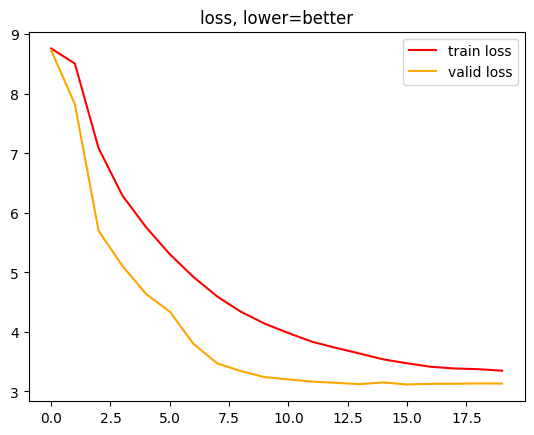

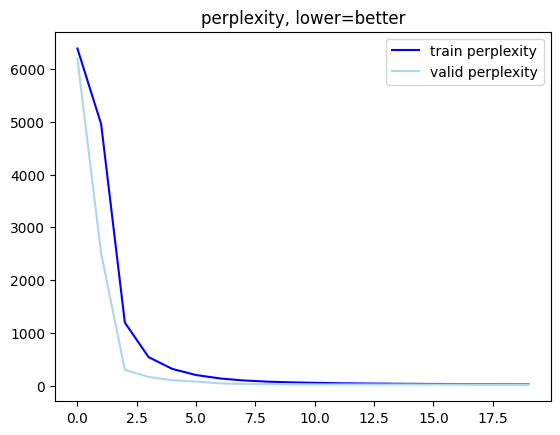

In [ ]:
TRAIN = True
if TRAIN:
    plt.plot(trainer.metrics['train_loss'],color='red',label='train loss')
    plt.plot(trainer.metrics['val_loss'],color='orange',label='valid loss')
    plt.title('loss, lower=better')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(trainer.metrics['train_perplexity'],color='blue',label='train perplexity')
    plt.plot(trainer.metrics['val_perplexity'],color='lightblue',label='valid perplexity')
    plt.title('perplexity, lower=better')
    plt.legend()
    plt.show()

# Predictions
---

In [ ]:
for i in range(5):
    det = False
    test = val_df.sample(n=1).values[0]
    test_img, test_caption = test[0],test[1]
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0.5,1.5)
    if i > 40:
        det = True
    gen_caption = trainer.generate_caption(test_img,temperature=t,deterministic=det)
    distilled_gen_caption = dist_trainer.generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"actual: {test_caption}\nmodel: {gen_caption}\ndist_model: {distilled_gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Conclusion
---

- Dataset options: Flickr8k, Flickr30k, MS-COCO
- The generations are good not great, can definitely train for a lot longer for better results
- Additional decoding strategies like beam, contrastive could've been implemented
